# 0.0 Imports

In [36]:
import numpy as np
import pandas as pd

from sklearn import ensemble
from boruta import BorutaPy
from matplotlib import pyplot as plt

## 0.1 Load data

In [37]:
train_data_preparation = catalog.load("train_data_preparation")
validation_data_preparation = catalog.load("validation_data_preparation")

[09/23/23 18:10:27] INFO     Loading data from 'train_data_preparation' (CSVDataSet)...         ]8;id=644865;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=907914;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'validation_data_preparation' (CSVDataSet)...    ]8;id=648235;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=59220;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

## 0.2 Helper Functions

In [38]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', train_data_preparation.shape[1])
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    return None

notebook_settings()

# 5.0 Feature Selection

In [39]:
cols_drop = ['show_id', 'date_added', 'rating']

# training dataset
y_train = train_data_preparation['rating']
x_train = train_data_preparation.drop(cols_drop, axis=1)

# validation dataset
y_val = validation_data_preparation['rating']
x_val = validation_data_preparation.drop(cols_drop, axis=1)

x_train.head()

,title,director,cast,country,release_year,listed_in,description,minutes,duration_bins,years_since_release,description_length,movie_stage,number_of_directors,number_of_casts,number_of_countrys,number_of_listed_ins,films_by_director,films_by_cast_member,films_per_country,films_per_genre
0,2650,0.001,2794,0.046,0.400,0.001,2424,0.920,3,-0.160,-0.400,0,0.000,-1.167,0.000,0.000,1.000,-0.473,0.132,-0.709
1,1611,0.000,1673,0.012,-6.600,0.001,2306,-0.252,3,5.440,0.000,1,0.000,-0.500,0.000,1.000,0.000,-0.378,0.033,-0.438
2,3064,0.000,863,0.001,0.000,0.001,92,0.033,3,0.000,0.500,1,0.000,0.333,0.000,1.000,0.000,-0.331,0.003,0.015
3,1481,0.000,1237,0.012,-0.200,0.037,1548,-1.637,2,0.480,-0.100,1,0.000,-1.167,0.000,0.500,0.000,-0.473,0.034,1.479
4,816,0.001,2307,0.169,-6.600,0.010,3324,1.844,3,5.280,-0.200,1,0.000,0.000,0.000,1.000,4.000,1.005,0.489,-0.312


## 5.1 Boruta as feature selector

In [ ]:
# training and test dataset for Boruta
X_train_boruta = x_train.values
y_train_boruta = y_train.values.ravel()

# define RandomForestRegressor
rf = ensemble.RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42, max_iter=200).fit(X_train_boruta, y_train_boruta)

Although we have the best columns it is interesting to analyze the weights, these weights correspond to which columns have the greatest impact on the prediction.

Unfortunately Boruta does not have a direct way to analyze the weights, but we can infer through less complex models to extract this information.

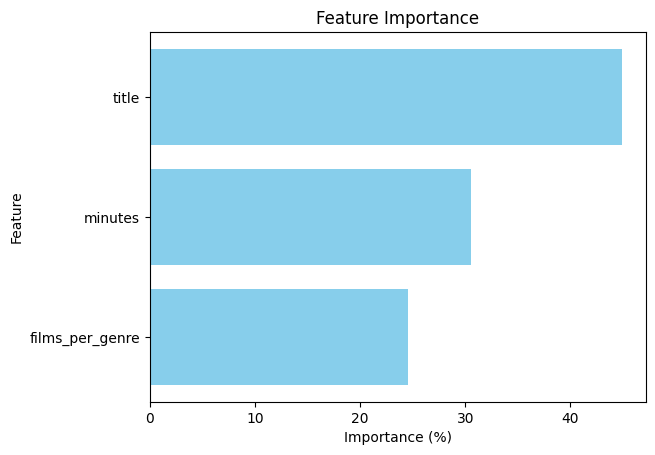

In [41]:
selected_features_mask = boruta.support_
selected_features = x_train.columns[selected_features_mask]
X_selected = x_train[selected_features]

rf.fit(X_selected, y_train)

importances_selected = rf.feature_importances_
importances_selected_perc = 100.0 * (importances_selected / importances_selected.sum())

importance_df = pd.DataFrame({'feature': selected_features, 'importance': importances_selected_perc})
importance_df = importance_df.sort_values(by='importance', ascending=True)

plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.show()

In [ ]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = x_train
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

We have 3 features, which isn't very many, so we'll use another technique to help us decide.

## 5.2 feature selection per importance

Feature ranking:
                feature  importance
0               minutes       0.115
0                 title       0.067
0          release_year       0.067
0             listed_in       0.064
0    description_length       0.064
0  films_by_cast_member       0.060
0       films_per_genre       0.059
0           description       0.059
0       number_of_casts       0.057
0                  cast       0.057
0               country       0.048
0   years_since_release       0.047
0     films_by_director       0.047
0     films_per_country       0.046
0              director       0.038
0  number_of_listed_ins       0.028
0   number_of_directors       0.020
0         duration_bins       0.020
0           movie_stage       0.019
0    number_of_countrys       0.017


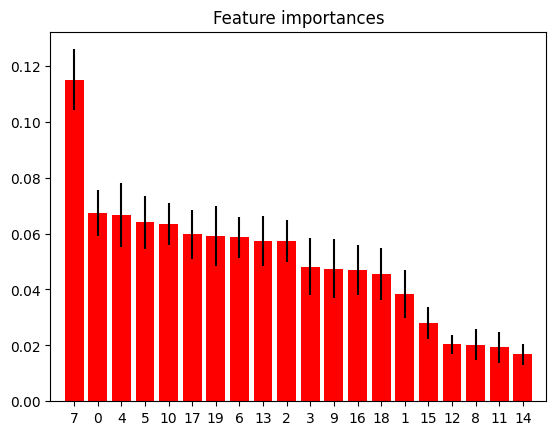

In [42]:
forest = ensemble.ExtraTreesRegressor(n_estimators=250, random_state=0, n_jobs=-1)

forest.fit(x_train, y_train)

# Collect features from model selector
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Organize and print ranking per features
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

Here we have the weights of the features for learning the model, one way would be to select the most impactful features until we reach one where the impact on its weight is considerably lower than the previous one, in this sense, I will choose up to the tenth feature.

## 5.3 Choice of features

In both cases we have the columns 'title', 'minutes', 'films_per_genre', from here we will make two decisions:
1) We will not use title, this feature is unique to each media and should not represent significant importance in the model.
2) We will use all the other features in the feature importance method.

In [51]:
cols_feature_importance = ['minutes', 'release_year', 'listed_in', 'description_length', 
                           'films_by_cast_member', 'films_per_genre', 'description', 
                           'number_of_casts', 'cast']

In [52]:
catalog.save("train_feature_selection", train_data_preparation[list(cols_feature_importance) + ['show_id', 'date_added', 'rating']])
catalog.save("validation_feature_selection", validation_data_preparation[list(cols_feature_importance) + ['show_id', 'date_added', 'rating']])

[09/23/23 18:22:33] INFO     Saving data to 'train_feature_selection' (CSVDataSet)...           ]8;id=394935;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=759135;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\

                    INFO     Saving data to 'validation_feature_selection' (CSVDataSet)...      ]8;id=918388;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=154571;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\